## On-policy learning and SARSA

This notebook builds on `qlearning.ipynb` to implement Expected Value SARSA.

The policy we're gonna use is epsilon-greedy policy, where agent takes optimal action with probability $(1-\epsilon)$, otherwise samples action at random. Note that agent __can__ occasionally sample optimal action during random sampling by pure chance.

In [1]:
#XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1
        
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from qlearning import QLearningAgent

class EVSarsaAgent(QLearningAgent):
    """ 
    An agent that changes some of q-learning functions to implement Expected Value SARSA. 
    Note: this demo assumes that your implementation of QLearningAgent.update uses get_value(next_state).
    If it doesn't, please add
        def update(self, state, action, reward, next_state):
            and implement it for Expected Value SARSA's V(s')
    """
    
    def get_value(self, state):
        """ 
        Returns Vpi for current state under epsilon-greedy policy:
          V_{pi}(s) = sum _{over a_i} {pi(a_i | s) * Q(s, a_i)}
          
        Hint: all other methods from QLearningAgent are still accessible.
        """
        epsilon = self.epsilon
        possible_actions = self.get_legal_actions(state)

        #If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0

        
        # <YOUR CODE HERE: SEE DOCSTRING>
        best_action = self.get_best_action(state)
        state_values = [self.get_qvalue(state, action) for action in possible_actions]
        state_value = np.sum(state_values) * epsilon / n_actions + (1 - epsilon) * self.get_qvalue(state, best_action)            
        
        return state_value

### Cliff World

Let's now see how our algorithm compares against q-learning in case where we force agent to explore all the time.

<img src=https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/cliffworld.png width=600>
<center><i>image by cs188</i></center>

In [3]:
import gym, gym.envs.toy_text
env = gym.envs.toy_text.CliffWalkingEnv()
n_actions = env.action_space.n

print(env.__doc__)


    This is a simple implementation of the Gridworld Cliff
    reinforcement learning task.

    Adapted from Example 6.6 (page 145) from Reinforcement Learning: An Introduction
    by Sutton and Barto:
    http://people.inf.elte.hu/lorincz/Files/RL_2006/SuttonBook.pdf
    
    With inspiration from:
    https://github.com/dennybritz/reinforcement-learning/blob/master/lib/envs/cliff_walking.py

    The board is a 4x12 matrix, with (using Numpy matrix indexing):
        [3, 0] as the start at bottom-left
        [3, 11] as the goal at bottom-right
        [3, 1..10] as the cliff at bottom-center

    Each time step incurs -1 reward, and stepping into the cliff incurs -100 reward 
    and a reset to the start. An episode terminates when the agent reaches the goal.
    


In [4]:
# Our cliffworld has one difference from what's on the image: there is no wall. 
# Agent can choose to go as close to the cliff as it wishes. x:start, T:exit, C:cliff, o: flat ground
env.render()

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



In [5]:
def play_and_train(env,agent,t_max=10**4):
    """This function should 
    - run a full game, actions given by agent.getAction(s)
    - train agent using agent.update(...) whenever possible
    - return total reward"""
    total_reward = 0.0
    s = env.reset()
    
    for t in range(t_max):
        a = agent.get_action(s)
        
        next_s,r,done,_ = env.step(a)
        agent.update(s, a, r, next_s)
        
        s = next_s
        total_reward +=r
        if done:break
        
    return total_reward


In [6]:
from qlearning import QLearningAgent

agent_sarsa = EVSarsaAgent(alpha=0.25, epsilon=0.2, discount=0.99,
                       get_legal_actions = lambda s: range(n_actions))

agent_ql = QLearningAgent(alpha=0.25, epsilon=0.2, discount=0.99,
                       get_legal_actions = lambda s: range(n_actions))

EVSARSA mean reward = -30.71
QLEARNING mean reward = -100.23


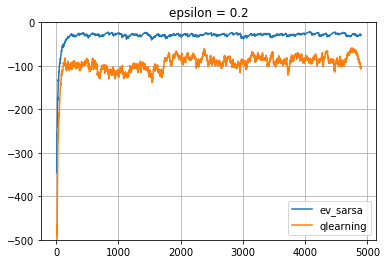

In [7]:
from IPython.display import clear_output
from pandas import ewma, Series
moving_average = lambda ts, span=100: ewma(Series(ts), min_periods=span//10, span=span).values

rewards_sarsa, rewards_ql = [], []

for i in range(5000):
    rewards_sarsa.append(play_and_train(env, agent_sarsa))
    rewards_ql.append(play_and_train(env, agent_ql))
    #Note: agent.epsilon stays constant
    
    if i %100 ==0:
        clear_output(True)
        print('EVSARSA mean reward =', np.mean(rewards_sarsa[-100:]))
        print('QLEARNING mean reward =', np.mean(rewards_ql[-100:]))
        plt.title("epsilon = %s" % agent_ql.epsilon)
        plt.plot(moving_average(rewards_sarsa), label='ev_sarsa')
        plt.plot(moving_average(rewards_ql), label='qlearning')
        plt.grid()
        plt.legend()
        plt.ylim(-500, 0)
        plt.show()
        

Let's now see what did the algorithms learn by visualizing their actions at every state.

In [8]:
def draw_policy(env, agent):
    """ Prints CliffWalkingEnv policy with arrows. Hard-coded. """
    n_rows, n_cols = env._cliff.shape
    
    actions = '^>v<'
    
    for yi in range(n_rows):
        for xi in range(n_cols):
            if env._cliff[yi, xi]:
                print(" C ", end='')
            elif (yi * n_cols + xi) == env.start_state_index:
                print(" X ", end='')
            elif (yi * n_cols + xi) == n_rows * n_cols - 1:
                print(" T ", end='')
            else:
                print(" %s " % actions[agent.get_best_action(yi * n_cols + xi)], end='')
        print()

In [9]:
print("Q-Learning")
draw_policy(env, agent_ql)

print("SARSA")
draw_policy(env, agent_sarsa)

Q-Learning
 v  >  >  >  >  >  >  v  v  >  >  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 
SARSA
 >  >  >  >  >  >  >  >  >  >  >  v 
 ^  ^  ^  >  >  >  >  >  >  >  >  v 
 ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 


### Submit to Coursera

In [10]:
from submit import submit_sarsa
submit_sarsa(rewards_ql, rewards_sarsa, 'gmail.com', 'token')

Submitted to Coursera platform. See results on assignment page!


### More

Here are some of the things you can do if you feel like it:

* Play with epsilon. See learned how policies change if you set epsilon to higher/lower values (e.g. 0.75).
* Expected Value SASRSA for softmax policy:
$$ \pi(a_i|s) = softmax({Q(s,a_i) \over \tau}) = {e ^ {Q(s,a_i)/ \tau}  \over {\sum_{a_j}  e ^{Q(s,a_j) / \tau }}} $$
* Implement N-step algorithms and TD($\lambda$): see [Sutton's book](http://incompleteideas.net/book/bookdraft2018jan1.pdf) chapter 7 and chapter 12.
* Use those algorithms to train on CartPole in previous / next assignment for this week.